### Authentication and other code admin

* Importing Python libraries
* Setting up Google Cloud Platform (GCP) services
    * Service account impersonation authentication and secrets retrieval 
    * Cloud storage access and file retrieval
* Getting files organized

#### Importing Python libraries

In [5]:
#data org/manipulation
import pandas as tian
tian.set_option('display.max_columns', None)
import numpy as np
from io import StringIO
import builtins
import pickle
import os
import random
from wordcloud import WordCloud as wc
import matplotlib.pyplot as plt


#tracking/loggin
from tqdm import tqdm
import logging
#gcp
from google.auth import default, impersonated_credentials
from google.cloud import secretmanager, storage

#llm libraries
from transformers import AutoTokenizer
from langchain import document_loaders
from langchain.text_splitter import RecursiveCharacterTextSplitter
import tensorflow as tf




#### Setting up Google Cloud Platform (GCP) services

##### Service account impersonation authentication and secrets retrieval 

You will need to change this to your preferred setup for accessing files and secrets if you want to follow along. My first start is authenticating into GCP from the command line:

```
gcloud auth application-default login
```


In [2]:
# Default credentials from the environment
credentials, project_id = default()
# service account impersonation setup
service_account_email = "gcp-music-service@thoughts-on-music.iam.gserviceaccount.com"
target_scopes = ['https://www.googleapis.com/auth/cloud-platform']

impersonated_credentials = impersonated_credentials.Credentials(
    source_credentials=credentials,
    target_principal=service_account_email,
    target_scopes=target_scopes
)

# secrets client
secret_client = secretmanager.SecretManagerServiceClient()
project_id = "thoughts-on-music"
secret_id = "HUGGING_FACE_READ_TOKEN_LLAMA"
version_id = "latest" 
secrets_name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

# retrieve HF API key from secrets manager
response = secret_client.access_secret_version(name=secrets_name)
HUGGING_FACE_READ_TOKEN_LLAMA = response.payload.data.decode("UTF-8")


##### Cloud storage access and file admin

I've defined a couple functions for used as needed:

* gcp_download takes a defined GPC bucket name, folder location, and file name and returns a dataframe of that file
    * It's designed so other bucket and folder names can be introduced without wrecking the code
* df_deets takes either a single dataframe name or a list of dataframe name and prints out details I like:
    * The name of the dataframe
    * The first few rows
    * The column names
    * The data types for each field
    * Sum of duplicates and NAs for each column 

In [3]:
# cloud storage client setup
storage_client = storage.Client(credentials=credentials)
love_uwsthoughts = "love-uwsthoughts"
bp_csvs_folder = 'bp_csvs'
bp_artist_bios_folder = 'bp_artist_bios'
uwsthoughts_bucket = storage_client.bucket(love_uwsthoughts)

#function to import files 
def gcp_download(bucket_name, gcp_folder, file_name):
    bucket = storage_client.bucket(bucket_name)
    blob_name = f"{gcp_folder}/{file_name}".strip("/")
    file_blob = bucket.blob(blob_name)
    file_data = file_blob.download_as_text() 
    gcp_df = tian.read_csv(StringIO(file_data))
    
    return gcp_df

def df_deets(df_or_names):
    def print_info(df, df_name):
        print(f"{df_name}:")
        if hasattr(builtins, "display"):
            display(df)
        else:
            print(df)
        print("\n")
        
        # Summary of data types, duplicates, NAs, and distinct values
        summary_df = tian.DataFrame({
            "Data types": df.dtypes,
            "Duplicates": [df.duplicated(subset=[col]).sum() for col in df.columns],
            "NAs": df.isna().sum().values,
            "Distinct values": df.nunique().values
        }).set_index(df.columns)
        
        print(f"{df_name} summary:")
        if hasattr(builtins, "display"):
            display(summary_df)
        else:
            print(summary_df)
        print("\n")
        print(df.columns)
        print("\n")
        total_duplicates = df.duplicated().sum()
        print(f"Total number of duplicate rows in {df_name}: {total_duplicates}\n")

    if isinstance(df_or_names, list): 
        for item in df_or_names:
            if isinstance(item, str):
                df = globals()[item] 
                print_info(df, item)
            else:
                print_info(item, "dataframe")
    else: 
        if isinstance(df_or_names, str):
            df = globals()[df_or_names]  
            print_info(df, df_or_names)
        else:
            print_info(df_or_names, "dataframe")


##### Getting files organized 

This may seem beautifully consolidated now but trust me when I say that there was a lot of chaos I went through to get to this point. I keep like with like to make it easier for me to remember what I was thinking.

Running list of different files I need at various points:

In [4]:
fact_bp_track_audio_features_csv = 'fact_bp_track_audio_features.csv' 
fact_bpmeta_audio_csv = 'fact_bpmeta_audio.csv'
fact_label_bpmeta_audio_csv = 'fact_label_bpmeta_audio.csv'
bp_artist_release_csv = 'bp_artist_release.csv'
bp_artist_csv = 'bp_artist.csv'
bp_artist_track_csv = 'bp_artist_track.csv'
bp_label_csv = 'bp_label.csv'
bp_genre_csv = 'bp_genre.csv'
bp_key_csv = 'bp_key.csv'
bp_label_artist_csv = 'bp_label_artist.csv'

I only had to download from GCP once and then I cached the ones I need for later use. If I make a change that I want to be permanent, I update the cache with the changes. From time to time I'll send a changed file up to GCP if I have a long term need for it. 

In [5]:
bp_artist_df = gcp_download(love_uwsthoughts, bp_csvs_folder, bp_artist_csv)
bp_artist_release_df =  gcp_download(love_uwsthoughts, bp_csvs_folder, bp_artist_release_csv)
bp_artist_track_df = gcp_download(love_uwsthoughts, bp_csvs_folder, bp_artist_track_csv)

bp_label_df = gcp_download(love_uwsthoughts, bp_csvs_folder, bp_label_csv)
bp_label_artist_df = gcp_download(love_uwsthoughts, bp_csvs_folder, bp_label_artist_csv)

bp_genre_df = gcp_download(love_uwsthoughts, bp_csvs_folder, bp_genre_csv)
bp_key_df = gcp_download(love_uwsthoughts, bp_csvs_folder, bp_key_csv)
fact_label_bpmeta_audio_df = gcp_download(love_uwsthoughts, bp_csvs_folder, fact_label_bpmeta_audio_csv)

fact_bp_track_audio_features_df = gcp_download(love_uwsthoughts, bp_csvs_folder, fact_bp_track_audio_features_csv)
fact_bpmeta_audio_df = gcp_download(love_uwsthoughts, bp_csvs_folder, fact_bpmeta_audio_csv)

bp_artist_df.to_parquet('bp_artist_df_cache.parquet', index=False)
bp_artist_release_df.to_parquet('bp_artist_release_df_cache.parquet', index=False)
bp_artist_track_df.to_parquet('bp_artist_track_df_cache.parquet', index=False)

bp_label_df.to_parquet('bp_label_df_cache.parquet', index=False)
bp_label_artist_df.to_parquet('bp_label_artist_df_cache.parquet', index=False)

bp_genre_df.to_parquet('bp_genre_df_cache.parquet', index=False)
bp_key_df.to_parquet('bp_key_df_cache.parquet', index=False)



/var/folders/z2/2cg34qq110n7hgx5hd3b2rnr0000gn/T/ipykernel_61237/3149298918.py:14: DtypeWarning: Columns (1,2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  gcp_df = tian.read_csv(StringIO(file_data))


A consolidated list of the cached dataframes I need:

In [7]:
bpmeta_audio_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bpmeta_audio_df_cache.parquet') # removed fact from name
bpmeta_audio_shield_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bpmeta_audio_shield_df_cache.parquet')

bp_artist_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_artist_df_cache.parquet')
bp_artist_release_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_artist_release_df_cache.parquet')
bp_artist_track_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_artist_track_df_cache.parquet')

bp_artist_label_names_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_artist_label_names_df_cache.parquet')
bp_artist_bios_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_artist_bios_df_cache.parquet')

bp_label_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_label_df_cache.parquet')
bp_label_artist_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_label_artist_df_cache.parquet')

bp_genre_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_genre_df_cache.parquet')
bp_key_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_key_df_cache.parquet')
bp_key_text_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_key_text_df_cache.parquet')

bp_text_values_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_text_values_df_cache.parquet')
bp_token_df = tian.read_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_caches/bp_token_df_cache.parquet')



### Data here, there, and everywhere

This first section is about futzing around with files I made when I was much younger, maybe early summer 2024? I'm going to sweep through and see which ones are actually valuable and which ones are the result of me wrapping myself in a massive vortext of delusion.

In [ ]:
fact_bp_track_audio_features_df = gcp_download(love_uwsthoughts, bp_csvs_folder, fact_bp_track_audio_features_csv)
fact_bpmeta_audio_df = gcp_download(love_uwsthoughts, bp_csvs_folder, fact_bpmeta_audio_csv)

In [ ]:
dataframes_list = ['fact_bp_track_audio_features_df', 'fact_bpmeta_audio_df']

df_deets(dataframes_list)

Based on the above, it looks like I intended for 'fact_bpmeta_audio_df' to be the cleaned up version of 'fact_bp_track_audio_features_df'. There were ~13,000 rows without Beatport track_id's and, given that this heavily revolves around Beatport data, I decided that it wasn't worth keeping records without that ID. While I do want to get the show on the road, I do have to return to  'mix' having 477,121 distinct values. The table above already has all the cleaned up values in place but below is how I previously did it. I've also added some data to show that we are dealing with the longest of longest tails for this one.

In [ ]:
bpmeta_audio_df = tian.merge(
    fact_bpmeta_audio_df,
    fact_bp_track_audio_features_df[['track_id', 'title', 'track_url']],
    on='track_id',
    how='left'
)

bpmeta_audio_df

In [ ]:
mix_replacements = {
    "continuous": "Set Mixed",
    "live": "Set Mixed",
    "remastered": "Remastered Mix",
    "orginal": "Original Mix",
    "ambient": "Ambient Mix",
    "chill": "Ambient Mix",
    "lounge": "Ambient Mix",
    "rework": "Remastered Mix",
    "remix": "Remix",
    "original": "Original Mix",
    "club": "Club Mix",
    "dub": "Dub Mix",
    "extended": "Extended Mix",
    "instrumental": "Instrumental Mix",
    "radio": "Radio Mix",
    "vip": "Remix",
    "album": "Album Mix",
    "Continuous DJ Mix": "Mixed",
    "Mix Cut": "Set Mixed",
    "Mixed": "Set Mixed",
    "Intro Mix": "Set Mixed",
    "Edit": "Radio Edit",
    "Main Mix": "Original Mix",
    "Album Version": "Album Mix",
    "Deep Mix": "Remix",
    "House Mix": "Remix",
    "Tribal Mix": "Remix",
    "Intro": "Set Mixed",
    "Edit Mix": "Radio Mix",
    "Bonus Track": "Album Mix"
}

# Function to clean up mix values
def clean_mix_values(mix):
    if isinstance(mix, str):
        for key, value in mix_replacements.items():
            if key.lower() in mix.lower():
                return value
    return mix


bpmeta_audio_df['mix'] = bpmeta_audio_df['mix'].apply(clean_mix_values)
total_rows = len(bpmeta_audio_df)
top_20 = bpmeta_audio_df['mix'].value_counts().head(20)
top_20_df = top_20.reset_index(name='count').rename(columns={'index': 'mix'})
top_20_df['percent_of_total'] = (top_20_df['count'] / total_rows) * 100

print("\nTop 20 mix values after cleanup:")
print(top_20_df)


I made the cache for bpmeta_audio_df down here and then moved the read cache part near the top with the rest. 

In [ ]:
bpmeta_audio_df.to_parquet('bpmeta_audio_df_cache.parquet', index=False)

### A suspicious label data table

I had an inkling that this old table I made was a botched attempt at joining label data to the other metadata. 

In [ ]:
df_deets(fact_label_bpmeta_audio_df)

Based on the above, that's exactly what happened. I'm willing to bet I can just append label_name onto fact_bpmeta_audio_df and have that be that.

In [ ]:
bpmeta_audio_shield_df = tian.merge(bpmeta_audio_df, fact_label_bpmeta_audio_df[['track_id', 'label_name']],
                     on='track_id', how='left')

bpmeta_audio_shield_df 

In [ ]:
bpmeta_audio_shield_df.to_parquet('bpmeta_audio_shield_df_cache.parquet', index=False)

df_deets(bpmeta_audio_shield_df)

### A big ol' effort to make human readable text

A lot of my previous work has been premised on using different IDs to establish realtionships between data, with text values only coming in at the very end to help identify outputs. Now that I'm shifting into trying to use a large language model, I want text values instead of IDs so the model can tokenize and understand what it means. My thinking is that these IDs probably won't mean too much to it but it's probably been trained on enough data that it can make relationships with the additional text data I give it. 

#### Miami = synergy

While each dataframe has it's column names printed as part of df_deets() above, for this specific part I needed all the column names neatly stacked on top of each other so I could figure out what needed to go where. I've been working with this data for a few months now so all these tables and fields mean something to me, with the samples above used as needed. The only one that isn't an original dataset is```bpmeta_audio_shield_df```.

In [ ]:
df_names = ["bpmeta_audio_shield_df", "bp_artist_df", "bp_artist_release_df", "bp_artist_track_df", "bp_label_df", "bp_label_artist_df", "bp_genre_df", "bp_key_df"]

for name, df in zip(df_names, df_list):
    print(f"{name}:\n {df.columns}\n")

Here's the best approach: use ```bpmeta_audio_shield_df``` as the starting point and add in text values where it made sense. I did this with a couple of goals in mind:

* Make copies of tables I want to change so that I can preserve original tables in their original structure
* Combine data that can realistically go together, like the data saying which artists are on which labels

#### From the underground to the world 

This first part is straight forward: there were separate tables for artist and label metadata and I wanted to see a label and its artists together. I thought of it has "Anjunadeep has Marsh and Eli & Fur as artists." I kept the IDs and urls but tucked them in at the end. My spider sense says having those urls available later is going to be useful.

In [ ]:
label_artist_temp = tian.merge(bp_label_artist_df, bp_label_df, on='label_id', suffixes=('', '_label'))
bp_artist_label_names_df = tian.merge(label_artist_temp, bp_artist_df, on='artist_id', suffixes=('', '_artist'))
bp_artist_label_names_df = bp_artist_label_names_df[[ 'label_name', 'artist_name', 'label_id', 'label_url', 'artist_id', 'artist_url']]


In [ ]:
df_deets(bp_artist_label_names_df)

In [ ]:
bp_artist_label_names_df.to_parquet('bp_artist_label_names_df_cache.parquet', index=False)


#### On Key

If you look above at ```bp_key_df``` you'll see a table where things like key_id, key name, chord, and whether it's sharp or flat are in separate columns. That's a great setup for a relationship database but I need something a bit more human readable to feed into my model. I'm going to make a new dataframe that has ``key_id`` and a new ```key_description``` that concatenates some other details into a human readable statement. I'll then be able to swap that descrption in for key_id in the next step.

In [28]:
bp_key_text_df = bp_key_df.copy()

def key_mapper(row):
    if row['is_sharp'] == 't':
        return f"{row['key_letter']}-sharp {row['chord_name']}"
    elif row['is_flat'] == 't':
        return f"{row['key_letter']}-flat {row['chord_name']}"
    else:
        return f"Natural {row['key_letter']} {row['chord_name']}"

bp_key_text_df['key_description'] = bp_key_text_df.apply(key_mapper, axis=1)

bp_key_text_df = bp_key_text_df[['key_id', 'key_description']]

In [30]:
bp_key_text_df.to_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_cachesbp_key_text_df_cache.parquet', index=False)


### Four to the floor

#### First swing - smash it all together

Take a deep breath with me. From the above, I wanted to be able to say something like the following:

> On August 18th, 2023, Mira released 'Celo' on Kiosk ID. Her first release in 2023, it was also her first foray into melodic house & techno. It brought a newer and edgier side to her growing repertoire.

That led me to a table design that look like this:

- release_date
- artist_name
- title
- label_name
- genre_name
- bpm
- key_id
- mix
- is_remixed
- is_remixer
- mode
- valence
- danceability
- energy
- speechiness
- loudness
- liveness
- instrumentalness
- acousticness
- isrc
- artist_id
- artist_url
- track_id
- track_url
- label_id
- label_url
- genre_id
- genre_url

All of the text values are one after another on the left, with IDs and urls at the end. I have text value descriptions for all these Spotift audio metrics so it's easy to see how those go from continuous 0-1 values to something a human can understand. But,as they say, that's a problem for a different day.

To do this, I simply joined on the different IDs I needed, with track_id being the center of gravity. For now, I decided to have one track ID for each artist, which means multiple track IDs for each artist. In future work, I want to put all the artists together since the human brain doesn't separate out artists on a track like that. 

You'll see in the next part why this was a mix of good ideas and bad. But I learned the hard way so I'll document my suffering.


In [32]:
bp_track_artist_merge = tian.merge(bpmeta_audio_shield_df, bp_artist_track_df, on='track_id', suffixes=('', '_artist'))
bp_track_artist_label_merge = tian.merge(bp_track_artist_merge, bp_artist_df, on='artist_id', suffixes=('', '_artist_info'))
bp_track_artist_label_merge = tian.merge(bp_track_artist_label_merge, bp_label_df, on='label_id', suffixes=('', '_label'))
bp_track_artist_label_merge = tian.merge(bp_track_artist_label_merge, bp_genre_df, on='genre_id', suffixes=('', '_genre'))
bp_track_artist_label_merge = tian.merge(bp_track_artist_label_merge, bp_key_text_df, on='key_id', suffixes=('', '_key'))

bp_text_values_df = bp_track_artist_label_merge[[
    'release_date', 'artist_name', 'title', 'label_name', 'duration', 'genre_name', 'bpm', 'key_description', 'mix', 'is_remixed', 'is_remixer',
    'mode', 'valence', 'danceability', 'energy', 'speechiness', 'loudness', 'liveness', 'instrumentalness', 'acousticness', 'isrc', 'artist_id',
    'artist_url', 'track_id', 'track_url', 'label_id', 'label_url', 'genre_id', 'genre_url', 'key_id'
]]

This brought me this beatifully massive table. On spec, it looks how I wanted. I need to handle things like ```is_remixed``` and ```is_remixer``` since they're telling the same story from different perspectives.

In [49]:
bp_text_values_df

,release_date,artist_name,title,label_name,duration,genre_name,bpm,key_description,mix,is_remixed,is_remixer,mode,valence,danceability,energy,speechiness,loudness,liveness,instrumentalness,acousticness,isrc,artist_id,artist_url,track_id,track_url,label_id,label_url,genre_id,genre_url,key_id
0,2022-06-24,Preja,Movha,Supadjs Projects,6:51,Amapiano,112.0,Natural A Minor,Main,f,f,0.0,0.367,0.732,0.492,0.2620,-10.961,0.2970,0.00000,0.247000,GBKQU2257859,1063851,beatport.com/artist/preja/1063851,16636568,beatport.com/track/movha/16636568,40460,beatport.com/label/supadjs-projects/40460,98,/genre/amapiano/98,8.0
1,2022-06-24,Sidney Saige Ausama,Movha,Supadjs Projects,6:51,Amapiano,112.0,Natural A Minor,Main,f,f,0.0,0.367,0.732,0.492,0.2620,-10.961,0.2970,0.00000,0.247000,GBKQU2257859,1063852,beatport.com/artist/sidney-saige-ausama/1063852,16636568,beatport.com/track/movha/16636568,40460,beatport.com/label/supadjs-projects/40460,98,/genre/amapiano/98,8.0
2,2022-01-28,LSDee,Ayeye,One Night Stand Distribution,6:20,Amapiano,112.0,Natural F Minor,Original Mix,f,f,1.0,0.504,0.875,0.556,0.0700,-7.754,0.0819,0.55300,0.090300,ZARQO2200001,213465,beatport.com/artist/lsdee/213465,16115373,beatport.com/track/ayeye/16115373,99208,beatport.com/label/one-night-stand-distributio...,98,/genre/amapiano/98,4.0
3,2021-10-01,Babalwa M,LalaBy,Mavuso Business Solutions,9:01,Amapiano,114.0,G-flat Minor,Outro,f,f,0.0,0.261,0.852,0.445,0.0514,-16.397,0.0366,0.14800,0.007190,ZAC012100398,1039645,beatport.com/artist/babalwa-m/1039645,16223521,beatport.com/track/lalaby/16223521,100342,beatport.com/label/mavuso-business-solutions/1...,98,/genre/amapiano/98,34.0
4,2021-10-01,Babalwa M,Jaiva,Mavuso Business Solutions,6:15,Amapiano,113.0,G-flat Minor,Original Mix,f,f,0.0,0.343,0.842,0.702,0.0667,-13.397,0.0253,0.03780,0.005390,ZAC012100395,1039645,beatport.com/artist/babalwa-m/1039645,16223515,beatport.com/track/jaiva/16223515,100342,beatport.com/label/mavuso-business-solutions/1...,98,/genre/amapiano/98,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9522072,2009-05-29,Steve O Steen,Breakfast In Illinois,Robsoul Recordings,4:37,Jackin House,127.0,Natural A Minor,Original Mix,f,f,1.0,0.677,0.806,0.773,0.0726,-11.024,0.1110,0.88000,0.000038,FR48Z0900019,107441,beatport.com/artist/steve-o-steen/107441,859924,beatport.com/track/breakfast-in-illinois/859924,2204,beatport.com/label/robsoul-recordings/2204,97,/genre/jackin-house/97,8.0
9522073,2009-05-29,Sam Karlson,Robsoul Boy,Robsoul Recordings,5:30,Jackin House,127.0,Natural B Major,Original Mix,f,f,1.0,0.912,0.890,0.772,0.1660,-5.031,0.0685,0.00071,0.180000,FR48Z0900018,9863,beatport.com/artist/sam-karlson/9863,859923,beatport.com/track/robsoul-boy/859923,2204,beatport.com/label/robsoul-recordings/2204,97,/genre/jackin-house/97,13.0
9522074,2009-05-29,Steve O Steen,Robsoul Boy,Robsoul Recordings,5:30,Jackin House,127.0,Natural B Major,Original Mix,f,f,1.0,0.912,0.890,0.772,0.1660,-5.031,0.0685,0.00071,0.180000,FR48Z0900018,107441,beatport.com/artist/steve-o-steen/107441,859923,beatport.com/track/robsoul-boy/859923,2204,beatport.com/label/robsoul-recordings/2204,97,/genre/jackin-house/97,13.0
9522075,2007-08-07,Colette,Hypnotized,OM Records,6:40,Jackin House,126.0,Natural F Major,Jason Hodges Mix,t,f,0.0,0.879,0.804,0.795,0.0715,-10.096,0.0494,0.82400,0.000029,USOM80795203,3201,beatport.com/artist/colette/3201,349708,beatport.com/track/hypnotized/349708,351,beatport.com/label/om-records/351,97,/genre/jackin-house/97,19.0


All of that work means I can also find artists I'm looking for much easier. Text values as IDs are, generally speaking, not great because it's easy to have overlaps and duplicates. For example, ```Mira (Berlin)``` has (Berlin) after her name because 1) she's from Berlin so it clearly identifies her and there's another ```Mira``` on Beatport and so someone has to change a bit. This is the divergence between the relational database world I've lived in and the more unstructured world of LLMs. I also didn't deal with ```bp_key_df``` meaningfully because it's a whole separate chunk of work to make it ready to add to this one. The key_id was preserved so I can easily return to it when ready. 

In [34]:
# bp_text_values_df[(bp_text_values_df['artist_name'] == 'Fideles') & (bp_text_values_df['title'] == 'Away With Me')].sort_values(by='release_date', ascending=False)
bp_text_values_df[bp_text_values_df['artist_name'] == 'Mira (Berlin)'].sort_values(by='release_date', ascending=False).head(10)


,release_date,artist_name,title,label_name,duration,genre_name,bpm,key_description,mix,is_remixed,is_remixer,mode,valence,danceability,energy,speechiness,loudness,liveness,instrumentalness,acousticness,isrc,artist_id,artist_url,track_id,track_url,label_id,label_url,genre_id,genre_url,key_id
7620604,2023-08-18,Mira (Berlin),Jero,Kiosk ID,10:05,Melodic House & Techno,116.0,Natural D Major,Original Mix,f,f,0.0,0.0378,0.760,0.728,0.0653,-11.191,0.1030,0.899,0.028600,DECY52301345,385397,beatport.com/artist/mira-berlin/385397,17993565,beatport.com/track/jero/17993565,80379,beatport.com/label/kiosk-id/80379,90,/genre/melodic-house-techno/90,22.0
7698958,2023-08-18,Mira (Berlin),Cleo,Kiosk ID,6:43,Melodic House & Techno,92.0,Natural G Major,Remix,t,f,1.0,0.1200,0.806,0.783,0.0461,-10.205,0.0660,0.946,0.077000,DECY52301349,385397,beatport.com/artist/mira-berlin/385397,17993576,beatport.com/track/cleo/17993576,80379,beatport.com/label/kiosk-id/80379,90,/genre/melodic-house-techno/90,21.0
7698955,2023-08-18,Mira (Berlin),Jero,Kiosk ID,8:38,Melodic House & Techno,119.0,Natural D Major,Remix,t,f,1.0,0.2670,0.830,0.350,0.0784,-9.705,0.0999,0.903,0.007660,DECY52301346,385397,beatport.com/artist/mira-berlin/385397,17993567,beatport.com/track/jero/17993567,80379,beatport.com/label/kiosk-id/80379,90,/genre/melodic-house-techno/90,22.0
7698952,2023-08-18,Mira (Berlin),Jero,Kiosk ID,5:56,Melodic House & Techno,120.0,Natural D Minor,Argia Powerbeats Version,t,f,1.0,0.0876,0.795,0.837,0.0449,-10.095,0.1050,0.833,0.000121,DECY52301347,385397,beatport.com/artist/mira-berlin/385397,17993570,beatport.com/track/jero/17993570,80379,beatport.com/label/kiosk-id/80379,90,/genre/melodic-house-techno/90,7.0
7660383,2023-08-18,Mira (Berlin),Cleo,Kiosk ID,6:18,Melodic House & Techno,114.0,Natural G Minor,Original Mix,f,f,0.0,0.1760,0.806,0.699,0.0451,-11.390,0.1200,0.939,0.014300,DECY52301348,385397,beatport.com/artist/mira-berlin/385397,17993573,beatport.com/track/cleo/17993573,80379,beatport.com/label/kiosk-id/80379,90,/genre/melodic-house-techno/90,6.0
5034902,2022-11-18,Mira (Berlin),Murmeli,Kiosk ID,6:32,Organic House / Downtempo,110.0,Natural C Major,Remix,t,t,1.0,0.1020,0.797,0.871,0.0544,-10.162,0.1500,0.896,0.056400,DECY52201887,385397,beatport.com/artist/mira-berlin/385397,17067088,beatport.com/track/murmeli/17067088,80379,beatport.com/label/kiosk-id/80379,93,/genre/organic-house-downtempo/93,20.0
5034956,2022-11-04,Mira (Berlin),Siriema,The Magic Movement,7:19,Organic House / Downtempo,108.0,Natural G Minor,Remix,t,t,0.0,0.7120,0.800,0.492,0.0649,-10.809,0.0840,0.894,0.081500,QM6P42229087,385397,beatport.com/artist/mira-berlin/385397,16935012,beatport.com/track/siriema/16935012,39677,beatport.com/label/the-magic-movement/39677,93,/genre/organic-house-downtempo/93,6.0
5034953,2022-11-04,Mira (Berlin),Siriema,The Magic Movement,7:19,Organic House / Downtempo,108.0,Natural G Minor,Remix,t,f,0.0,0.7120,0.800,0.492,0.0649,-10.809,0.0840,0.894,0.081500,QM6P42229087,385397,beatport.com/artist/mira-berlin/385397,16935012,beatport.com/track/siriema/16935012,39677,beatport.com/label/the-magic-movement/39677,93,/genre/organic-house-downtempo/93,6.0
5034958,2022-10-14,Mira (Berlin),Siriema,The Magic Movement,7:19,Organic House / Downtempo,108.0,Natural G Minor,Remix,f,f,0.0,0.7120,0.800,0.492,0.0649,-10.809,0.0840,0.894,0.081500,QM6P42229087,385397,beatport.com/artist/mira-berlin/385397,16947157,beatport.com/track/siriema/16947157,39677,beatport.com/label/the-magic-movement/39677,93,/genre/organic-house-downtempo/93,6.0
5060891,2022-09-09,Mira (Berlin),Higher Than Me,Frau Blau,7:21,Organic House / Downtempo,114.0,Natural D Major,Remix,t,t,1.0,0.2090,0.809,0.798,0.0613,-10.140,0.0666,0.840,0.077800,IL4612200064,385397,beatport.com/artist/mira-berlin/385397,16780144,beatport.com/track/higher-than-me/16780144,74969,beatport.com/label/frau-blau/74969,93,/genre/organic-house-downtempo/93,22.0


In [35]:
bp_text_values_df.to_parquet('/Users/uwsthoughts/Desktop/dolly_shield_local/parquet_cachesbp_text_values_df_cache.parquet', index=False)


### Artist bios integration

Running parallel to all of this, I scraped artist bios from Beatport in batches of 1,000 that were initially stored in separate files. This is where I smashed them all together and removes some duplicates. I'll use this data dowwn the line. Part one is just getting organized. 


In [ ]:
#sort folder by created date and then grab
def gcp_folder_sort(bucket, folder):
    blobs = list(bucket.list_blobs(prefix=folder))
    sorted_blobs = sorted(blobs, key=lambda x: x.time_created)
    return sorted_blobs

#combine csv files into one df
def artists_united(bucket, folder):
    sorted_blobs = gcp_folder_sort(bucket, folder)
    artists_united_df = tian.DataFrame()
    for blob in sorted_blobs:
        if blob.name.endswith('.csv'):
            the_drop = gcp_download(bucket.name, folder, blob.name.split('/')[-1])
            the_drop = the_drop[['beatport_artist_id', 'artist_name', 'beatport_bio']]
            artists_united_df = tian.concat([artists_united_df, the_drop], ignore_index=True)
    artists_united_df = artists_united_df.drop_duplicates(ignore_index=True)        
    return artists_united_df

#save df back to gcp
def paranoid_guard(df, bucket_name, gcp_folder, file_name):
    bucket = storage_client.bucket(bucket_name)
    csv_data = df.to_csv(index=False)
    blob_name = f"{gcp_folder}/{file_name}".strip("/")
    blob = bucket.blob(blob_name)
    blob.upload_from_string(csv_data, content_type='text/csv')


In [ ]:
bppoints_artist_bios_csv = "bppoints_artist_bios.csv"

bppoints_artist_bios_df = artists_united(uwsthoughts_bucket, bp_artist_bios_folder)

paranoid_guard(bppoints_artist_bios_df, love_uwsthoughts, bp_artist_bios_folder, bppoints_artist_bios_csv)

I decided I was only interested in the artists that had a bio so of the ~55,000 I started with, I ended up with ~48,000. I moved the df_deets() for it up with the rest after I finished.

In [ ]:
artist_bios_df = bppoints_artist_bios_df.drop_duplicates(subset='beatport_bio', keep='first')
artist_bios_df.to_csv('/Users/uwsthoughts/Desktop/bp_spotify_raw_data/csv_data/artist_bios_df.csv', index=False)
artist_bios_df.to_parquet('artist_bios_df_cache.parquet', index=False)

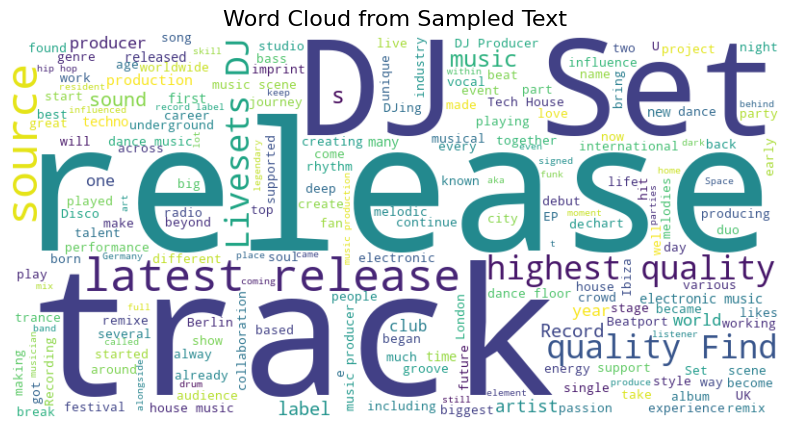

In [6]:
import csv
import random

# File path to your CSV file
file_path = '/Users/uwsthoughts/Desktop/bp_spotify_raw_data/csv_data/artist_bios_df.csv'

# Parameters
sample_size = 10000  # Define how many lines you'd like to sample

# Get the total number of lines in the CSV file
with open(file_path, 'r', encoding='utf-8') as file:
    total_lines = sum(1 for line in file) - 1  # Subtract 1 to account for the header

# Generate random line numbers to sample, without needing to load all lines
sample_lines = set(random.sample(range(1, total_lines + 1), min(sample_size, total_lines)))

# Extract the sampled lines to create the word cloud text
sampled_text = ""
with open(file_path, 'r', encoding='utf-8') as file:
    reader = csv.DictReader(file)
    for i, row in enumerate(reader):
        if i in sample_lines:
            sampled_text += row['beatport_bio'] + " "  # Replace 'bio' with the actual column name containing text data

# Create the word cloud
wordcloud = wc(width=800, height=400, background_color='white').generate(sampled_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Sampled Text', fontsize=16)
plt.show()


## Tokenizing Work

Initial work using Hugging Face and Langchain to access and use the folllowing open source Large Language Models (LLMs):

* [Meta's Llama 3.1-8B](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1#llama-3.1)
* [Meta's Llama-3.2-11B-Vision](https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_2#-llama-3.2-vision-models-(11b/90b)-)


In [11]:
llama_318b = "meta-llama/Meta-Llama-3.1-8B"
llama_318b_tokenizer = AutoTokenizer.from_pretrained(llama_318b, token="HUGGING_FACE_READ_TOKEN_LLAMA")

llama_3211b = "meta-llama/Llama-3.2-11B-Vision"
llama_3211b_tokenizer = AutoTokenizer.from_pretrained(llama_3211b)

def melodies(row):
    text = (
        f"Track ID: {row['track_id']}, Title: {row['title']}, "
        f"Artist: {row['artist_name']}, Artist ID: {row['artist_id']}, "
        f"Genre: {row['genre_name']}, Genre ID: {row['genre_id']}, "
        f"Label: {row['label_name']}, Label ID: {row['label_id']}, "
        f"Release Date: {row['release_date']}, Track URL: {row['track_url']}, "
        f"Mix: {row['mix']}, Remix: {'Yes' if row['is_remixed'] else 'No'}, "
        f"Remixer: {'Yes' if row['is_remixer'] else 'No'}, Duration: {row['duration']} minutes, "
        f"BPM: {row['bpm']}, Key ID: {row['key_id']}, "
        f"Mode: {row['mode']}, Valence: {row['valence']}, Danceability: {row['danceability']}, "
        f"Energy: {row['energy']}, Speechiness: {row['speechiness']}, "
        f"Loudness: {row['loudness']}, Liveness: {row['liveness']}, "
        f"Instrumentalness: {row['instrumentalness']}, Acousticness: {row['acousticness']}, "
        f"ISRC: {row['isrc']}, Artist URL: {row['artist_url']}, Label URL: {row['label_url']}, "
        f"Genre URL: {row['genre_url']}."
    )
    return text

def find_your_flow(dataframe, farm_trips):
    hay_barrels = (len(dataframe) // farm_trips) + 1
    full_shed = []

    for i in range(0, hay_barrels, 20):
        last_barrel = min(i + 20, hay_barrels)
        for barrel in tqdm(range(i, last_barrel), desc=f"Processing batches {i+1}-{last_barrel}"):
            fresh_cut = barrel * farm_trips
            full_up = min((barrel + 1) * farm_trips, len(dataframe))
            batch_df = dataframe.iloc[fresh_cut:full_up]
            
            full_barrel = [melodies(row) for _, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Processing batch {barrel+1}/{hay_barrels}")]
            full_shed.extend(full_barrel)
    
    return full_shed


def dolly_tunes(texts, farm_trips):
    hay_barrels = (len(texts) // farm_trips) + 1
    dolly_grazing = []

    for i in range(0, hay_barrels, 20):
        last_barrel = min(i + 20, hay_barrels)
        for barrel in tqdm(range(i, last_barrel), desc=f"Tokenizing batches {i+1}-{last_barrel}"):
            fresh_cut = barrel * farm_trips
            full_up = min((barrel + 1) * farm_trips, len(texts))
            full_barrel = texts[fresh_cut:full_up]
            
            full_truck = llama_3211b_tokenizer(full_barrel, return_tensors="tf", truncation=True, padding=True)
            dolly_grazing.append(full_truck)
    
    return dolly_grazing


Before I got the above to run successfully (with the output shown below), I initially decided to [f'around and find out](https://www.youtube.com/watch?v=WntjAM2wqF8) and see what happens when you try and tokenize a nine million row datadframe in one batch. Surprise! It caused the kernel to crash. Another setback for toxic masculinity. After 46 minutes, I made it to here in my tracking:

```log
Generating texts: 100%|██████████| 9522077/9522077 [04:59<00:00, 31748.96it/s]
Tokenizing texts... This may take a while.


```

When I got this error message:

```log
The Kernel crashed while executing code in the current cell or a previous cell. 
Please review the code in the cell(s) to identify a possible cause of the failure. 
Click [here](https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes) for more info. 
View Jupyter log for further details.
```

I twirled down to the Jupyter logs and found this error message:

``` shell
}
13:48:29.846 [error] Disposing session as kernel process died ExitCode: undefined, Reason: 
13:49:13.917 [error] Failed to write data to the kernel channel shell [
  <Buffer 3c 49 44 53 7c 4d 53 47 3e>,
  <Buffer 38 64 39 65 37 36 61 37 64 33 61 34 64 62 66 38 38 32 33 32 34 64 63 34 62 34 66 35 65 34 34 36 30 31 37 36 36 36 33 38 34 62 39 66 64 34 61 34 30 30 ... 14 more bytes>,
  <Buffer 7b 22 64 61 74 65 22 3a 22 32 30 32 34 2d 30 39 2d 32 39 54 31 37 3a 34 39 3a 31 33 2e 39 31 37 5a 22 2c 22 6d 73 67 5f 69 64 22 3a 22 38 31 65 63 36 ... 177 more bytes>,
  <Buffer 7b 7d>,
  <Buffer 7b 7d>,
  <Buffer 7b 22 73 69 6c 65 6e 74 22 3a 66 61 6c 73 65 2c 22 73 74 6f 72 65 5f 68 69 73 74 6f 72 79 22 3a 66 61 6c 73 65 2c 22 75 73 65 72 5f 65 78 70 72 65 73 ... 1058 more bytes>
] [Error: Socket is closed
  at a.postToSocket (/Users/~/.cursor/extensions/ms-toolsai.jupyter-2024.6.0-darwin-arm64/dist/extension.node.js:304:8043)
  at /Users/~/.cursor/extensions/ms-toolsai.jupyter-2024.6.0-darwin-arm64/dist/extension.node.js:304:7787] {
  errno: 9,
  code: 'EBADF'
}

```


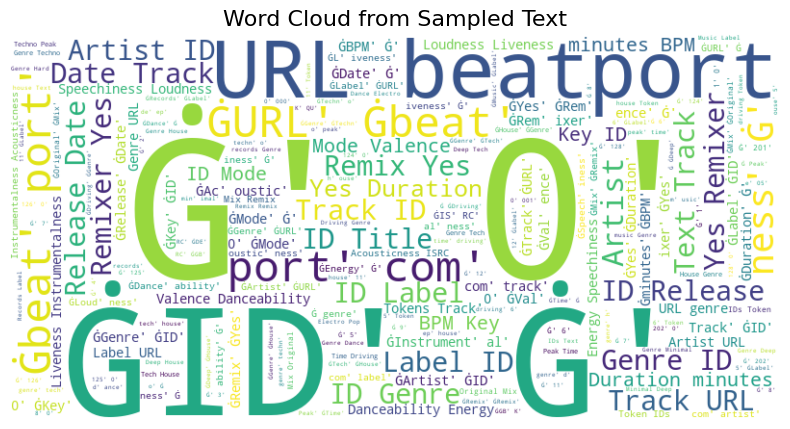

In [9]:
# File path
file_path = '/Users/uwsthoughts/Desktop/dolly_shield_local/tokenization_outputs/tokenization_log.txt'

# Parameters
sample_size = 10000  # Define how many lines you'd like to sample

# Get the total number of lines in the file in a memory-efficient way
total_lines = 0
with open(file_path, 'r', encoding='utf-8') as file:
    for _ in file:
        total_lines += 1

# Generate random line numbers to sample, without needing to load all lines
sample_lines = set(random.sample(range(total_lines), min(sample_size, total_lines)))

# Extract the sampled lines to create the word cloud text
sampled_text = ""
with open(file_path, 'r', encoding='utf-8') as file:
    for i, line in enumerate(file):
        if i in sample_lines:
            sampled_text += line + " "

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sampled_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud from Sampled Text', fontsize=16)
plt.show()


## Next steps

Well, once I got tokenization going, though, I read up (asked ChatGPT some questions) a bit more and determined there were things I could do better. For one, just giving an LLM a continuous metric (like 'valence' or 'energy' with values between 0 and 1) without any context to guide it will result in the song metadata being completely severed from its numeric qualities. In part two, I'll need to normalize the numeric values and encode them into embeddings (large numeric vectors representing words) using projections, which is a linear algebra term for mapping data into a space that’s compatible with the model’s vector representations. This allows the numeric data to be effectively integrated with text embeddings in a unified space. I can then do some math to make sure my vectors vibe with how the LLaMA model sees the world.

Mercifully, the text parts (song name, genre, artist name, etc.) can go through a standard tokenization and embedding using a similar tokenizer to what I used here. The result of this is a very large 3-D graph plane, more or less—numbers everywhere.

---gif of math

I can then smash the separate embeddings into a, like, super embedding or something, If I do this right (lol), the songs will be reunited with their metrics and everyone will vibe some more. This combined data, after all that huffin' and puffing, can be fed into the Llama model for training and optimization. 


In [ ]:
farm_trips = 50000
bp_text_values = find_your_flow(bp_text_values_df, farm_trips)

In [ ]:
bp_text_tokens = dolly_tunes(bp_text_values, farm_trips)